# Neighbourhood Analysis – Chennai, South India
Author: Poongodi P 

June 12, 2021

### Introduction and Business problem:

This project leverages Datascience skills to analyse the neighbourhoods of Chennai, South India. Chennai also known as Madras is the capital city of Indian State of TamilNadu. 

We will try to **propose few optimal locations to open a new shopping mall** in the city. Chennai hosts a large number of shopping malls across the city. This report also provides a brief analysis of existing shopping malls. 

Deciding where to put your business is as important as the business you decide to go. Intended **audience** of this report would be **large scale entrepreneurs** who wish to know about optimal locations in Chennai city to open their new business specifically a shopping mall. This report also gives them basic understanding about the existing malls in Chennai city. 

Note: This project can also be extended for other businesses such as restaurants or electronic shops with little modifications. 

### Data:

Success of a mall is directly proportional to the customer traffic. Our logic behind this project is to find out the places in the city where the **spending population traffic is high with no malls existing nearby**.

We will need the following data:

a)	Locations of **existing shopping malls** in the city
b)	**Population** distribution of the city
c)	Locations of **spending population** in the city

#### Data source:

   a)	Locations of existing shopping malls are obtained using FoursquareAPI. Premium details such as rating and reviews for each shopping mall are gathered using FoursquareAPI premium services. 

   b) Population distribution of Chennai :
	Latest census data for Chennai is available for the year 2011. Ward wise population (A city is divided into wards for administrative purposes – similar to boroughs) for Chennai is obtained from District Census Hand Book (DCHB) from census website of India
    Choropleth map will be a good choice to visualize the population distribution. To plot choropleth we need to get shape/geojson file for Chennai. Thanks to https://github.com/mickeykedia/India-Maps for the the geojson, shape and allied files for Chennai city!

   c)	Details of prime localities and popular IT parks are collected from Wikipedia. Localities include major IT parks and large residential localities.
   
### Methodology:
**Filter the locations that have high spending population with less number of high or medium rated malls nearby**


#### Steps Involved:

Chennai city is divided into 200 wards. We will analyse the localities ward wise. 

1. Get details of **existing malls** in the city using Foursquare API. Create a dataframe with the following fields: Mall Name, Latitude, Longitude, Mall Id. Visualize the **locations** of existing malls using folium map
2. Get **rating and tips** for all the malls using Foursqure API
3. Using KMeans clustering Machine Learning Model, group the malls into three categories. Visualize the groupings using **folium map**. Extract high and medium rated malls.
4. Print a **table** showing the existing malls, thier address, ratings and reviews.
5. Load Chennai ward wise **population data** into a dataframe. Load the Chennai geojson file using geopandas library. Merge population data with geojson using ward number to get the geometry of wards. Visualize the distribution using **choropleth map**
6. Load details of **spending population localities** to a dataframe(Columns: name and address) .Use geodecoder to get geographical coordinates (Lat and Lng) from address. Plot the localities in the above choropleth map.
7. List out top 10 wards with high population density. Gather top 10 wards holding large number of spending localities. See if there are **wards that have both high population and spending localities**.  
8. **Group the spending localities based on location using Kmeans clustering**. Plot them. Also plot all the existing malls in the same map. Filter only the **groups that enclose large number of prime localities without malls nearby**. 
9. Group the filtered clusters further based on location. Now use only high and medium rated malls nearby to predict competition.
9. For each group find the **mean of latitude and longitude**. Calculate number of high and medium rated malls within 3 kms from the filtered localities. These are the recommended locations for the stakeholders to consider.


In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
import requests
import folium
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import geopandas as gpd

import re

from geopy.distance import geodesic

Get geographical coordinates of 'Chennai'


In [3]:
#Get geographical coordinates of 'Chennai'
geolocator = Nominatim(user_agent = "myproj")
location = geolocator.geocode("Chennai")
chelat = location.latitude
chelng = location.longitude
print ('Chennai Latitude : ',chelat)
print('Chennai Longitude : ', chelng)

Chennai Latitude :  13.0836939
Chennai Longitude :  80.270186


### Analyse the existing shopping malls in Chennai

We use FourSquare API.

Define Foursquare user credentials

In [4]:
CLIENT_ID = 'QLC5EZDVB2SQCMRPGBFBBOGZQNREZUAMDLETMVYJBVZG54JE' # your Foursquare ID
CLIENT_SECRET = 'MOUYDEH1E1IXRFQWOZS3NH35V2OU5F4INQFNAZN43CSCNIFW' # your Foursquare Secret

VERSION = '20180605' # Foursquare API version


##### FourSquare API url components:

1. Use 'Search' endpoint
2. Use CategoryId parameter to pass the category ID of 'Shopping Mall' (4bf58dd8d48988d1fd941735'). Get the various category id from forusquare documentation https://developer.foursquare.com/docs/build-with-foursquare/categories/
3. Use 'query' parameter to list only the category 'Shopping Mall'
4. We will not pass radius so that 'city-wide' search is performed
5. We will pass limit the maximum value i.e 1000


API will look like:
	https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&query={}&limit={}.
    From the resulting JSON extract name, venue id, latitude and longitude for all the returned venues.



In [5]:
limit=1000
Catid = '4bf58dd8d48988d1fd941735'
query = 'Shopping Mall'
#Create the API request url
URL = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&query={}&limit={}'.format(  
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            chelat, 
            chelng,
            Catid,
            query,
            limit)
#Make the request
results = requests.get(URL).json()['response']['venues']


Load data to a dataframe

In [6]:
#Initialize a list
pd.set_option('display.max_rows', 10)
lstDetails = []

for i in range(len(results)):
        lstDetails.append([(results[i]['name'],
        results[i]['location']['lat'],
        results[i]['location']['lng'],
        results[i]['id'])])
        
dfBase = pd.DataFrame([item for lstDetails in lstDetails for item in lstDetails])
dfBase.columns = ['Mall Name', 'Latitude', 'Longitude','Id']
dfBase.sort_values(['Latitude']).head(3)

Mall Name   Latitude  Longitude                        Id
31  The Marina Mall  12.835812  80.228711  5c680061f62e09002ca0353a
30         BMR Mall  12.843260  80.227190  5c46e7ff4f0e58002cc1fa00
29      Vivira mall  12.850397  80.225931  5859648c2f91cb678271327b

#### Let's visualize the locations of malls

We will use folium library

In [86]:

map_malls = folium.Map(location = [chelat, chelng],zoom_start = 10)

#Add title to the map
title_html = '''<h3 align="center" style="font-size:20px"><b>Locations of Shopping Malls in Chennai, India</b></h3>'''
map_malls.get_root().html.add_child(folium.Element(title_html))

#Add markers to map
for lat,lng,label in zip(dfBase['Latitude'],dfBase['Longitude'],dfBase['Mall Name']):
 
    label = folium.Popup(label,parse_html = True)
    
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        color ='darkred',
        fill = True,
        fill_color = 'pink',
        fill_opacity = 0.5,
        parse_html = False).add_to(map_malls)


map_malls.save('malls.html')
map_malls

Looks Good! Now lets get **reviews and ratings** for the malls

To fetch ratings and reviews from Foursquare API use its premium call for vanues with venue id being endpoint:

https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}

Here venue id from previous result is passed to get the ratings for individual venues. Since this is a premium call, we will be able to execute this API only once per venue per day.  From the resulting JSON extract ratings and tips. 

In [8]:
lstrating = []
lsttip = []
#We need to use venue id as endpoint

#Loop through the mall dataset 
for venueid in dfBase['Id']:
    
    
    #Create the API request url
    URL = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(  
            venueid,       
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    #URL = 'https://api.foursquare.com/v2/venues/{}?'.format(venueid)
    #Make the request
   # try:
    preresult = requests.get(URL).json()['response']['venue']
    #except:
     #   preresult=''
    try:
        lstrating.append(preresult['rating'])
    except:
        lstrating.append(0)

    try:
        lsttip.append(preresult['tips']['groups'][0]['items'][0]['text'])
    except:
        lsttip.append('No reviews')

In [9]:
#Add the details to base dataframe
dfBase['Rating'] = lstrating
dfBase['Reviews'] = lsttip
dfBase.head(2)

Mall Name   Latitude  Longitude                        Id  Rating  \
0  Abirami Mega Mall  13.085900  80.248159  4c01fd3ea8e676b0cbddc532     5.2   
1          Alsa Mall  13.068889  80.257372  4be546125254d13abf8160e1     5.8   

                                             Reviews  
0  Go to Abirami Theatre and experience the newly...  
1  Bad place to come by car coz they don't have s...

#### Group the malls based on Location and Rating using KMeans clustering model

Lets now have a look at various kinds of malls that are existing

**KMeans** clustering machine learning model is used to group the venues based on rating. On plotting the data using folium library we will get a picture of locations of existing malls and groupings of similar kind of malls. At this point stakeholders will get an idea about the existing business situation in the city. 


#### Use k-means cluster model to group similar type of malls into clusters

Lets group the malls into 3 clusters

In [10]:
#dfBase.drop('Group', inplace =True, axis=1)

In [11]:
kclusters = 3
dfCluster = pd.DataFrame(dfBase[['Rating','Latitude','Longitude']])
kmeans = KMeans(n_clusters = kclusters, random_state = 4).fit(dfCluster)
dfBase.insert(5,'Group',kmeans.labels_)
dfBase.head(3)
dfBase.sort_values('Rating',ascending = False, inplace = True)

#### Print the mall details along with cluster labels, rating and address

Now Foursquare API does not return proper address for all the malls. So let us get the landmarks from the latitude and longitude values.

ress using geocode

In [12]:
#Get the landmarks for the malls
lstaddress=[]
geolocator = Nominatim(user_agent = "geo")

for lat,lng in zip(dfBase['Latitude'],dfBase['Longitude']):
    address = geolocator.reverse((lat,lng)).address
    tmp = address.split(',')
    lstaddress.append(','.join(tmp[1:3]))

Print to provide a clear picture of our findings

In [13]:
#Create a new dataframe that will list Name,Address,Rating,cluster label and reviews

dfPrint = pd.DataFrame(dfBase[['Mall Name']])
dfPrint['Address'] = lstaddress
dfPrint[['Rating','Reviews']] =  dfBase[['Rating', 'Reviews']]
dfPrint.sort_values('Rating',ascending = False)
dfPrint.reset_index(drop = True).head(10)


Mall Name  \
0             Express Avenue   
1                 VR Chennai   
2        Phoenix Market City   
3      The Forum Vijaya Mall   
4                  Alsa Mall   
5        Chennai Citi Centre   
6               Ampa Skywalk   
7             The Grand Mall   
8          Abirami Mega Mall   
9  Grand Venus Spectrum Mall   

                                            Address  Rating  \
0                                    2, Whites Road     7.7   
1    Jawaharlal Nehru Road (100 Feet Road), Ward 99     7.6   
2               Velachery Bypass Road, Gangai Nagar     7.0   
3                             Ponammal St, Ward 130     6.6   
4                             Montieth Road, Egmore     5.8   
5                     10/11, Dr Radhakrishnan Salai     5.5   
6                 Nelson Manickam Road, Aminjikarai     5.4   
7   Dr.Seetharaman Nagar Main Road, VGP Selva Nagar     5.2   
8                      Purusawalkam High Rd, Kellys     5.2   
9                     Paper Mills Rd, Periyar Nagar     5.1   

                                             Reviews  
0  avoid on Sundays!! way too many people- parkin...  
1  So many choices n unimaginable collections. Go...  
2  Free WiFi by Tikona. You'l receive a PIN numbe...  
3  IMAX will be ready by march !! Told by mall st...  
4  Bad place to come by car coz they don't have s...  
5    McD's roof top recommended for evening hangout!  
6  Be prepared for a good parking charge! And als...  
7              Grand is in name only!! Nothing Grand  
8  Go to Abirami Theatre and experience the newly...  
9  Horrible experience to travel to this place. T...

### Visualize mall clusters based on location and rating

We will use folium map

In [14]:

# create map
map_clusters = folium.Map(location=[chelat, chelng], zoom_start=11)


#Add title to the map
title_html = '''<h3 align="center" style="font-size:20px"><b>Clusters of Shopping Malls in Chennai, India</b></h3>'''
map_clusters.get_root().html.add_child(folium.Element(title_html))


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, name,rating,cluster in zip(dfBase['Latitude'], dfBase['Longitude'], dfBase['Mall Name'], dfBase['Rating'], dfBase['Group']):
    label = folium.Popup(str(name) + '  Rating: ' + str(rating) + '  Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters



From the map above, we can categorize the malls as follows:  
1. Malls that are highly rated
2. Malls that are moderately rated
3. Malls that have no rating or poorly rated

Important point to be noted here is that **the Foursquare site does not have ratings for many of the malls**. Since the project requires to use Foursquare API, I did not go for other options. 


### Let us have High and medium rated mall as a feature set in our model to predict competition level

Extract them to a dataset

In [54]:
dfRated = dfBase[(dfBase['Group'] == 2) | (dfBase['Group'] == 1)]
dfRated

Mall Name   Latitude  Longitude                        Id  \
8              Express Avenue  13.058705  80.264205  4bf3d4eed2fbef3b05b1a4c5   
19                 VR Chennai  13.080651  80.197441  5a8408fedb1d8121791ecdfe   
26        Phoenix Market City  12.991710  80.217297  4fe16257e4b0e4cc311bb9ab   
17      The Forum Vijaya Mall  13.050978  80.209526  5183b0fc498eb93b9fef543b   
1                   Alsa Mall  13.068889  80.257372  4be546125254d13abf8160e1   
..                        ...        ...        ...                       ...   
22             The Grand Mall  12.972018  80.220384  4d70d250d0f6a09051189462   
0           Abirami Mega Mall  13.085900  80.248159  4c01fd3ea8e676b0cbddc532   
3   Grand Venus Spectrum Mall  13.112524  80.236315  4fe494ade4b04d21c338491f   
12            Saravana Stores  13.041091  80.232123  4cd19ab19d87224b80cf5b3b   
20         Chandra Metro Mall  13.046714  80.190473  4e27faed62e17c330198fbf5   

    Rating  Group  \
8      7.7      2   
19     7.6      2   
26     7.0      2   
17     6.6      2   
1      5.8      1   
..     ...    ...   
22     5.2      1   
0      5.2      1   
3      5.1      1   
12     4.9      1   
20     4.9      1   

                                                                                                                                                                                                     Reviews  
8                                                                                                            avoid on Sundays!! way too many people- parking gets full, overdose of body odor & rowdy crowd!  
19                                                                                                                                                    So many choices n unimaginable collections. Good Mall.  
26                                                              Free WiFi by Tikona. You'l receive a PIN number through SMS, once you register in the Tikona's login page. Then you can access the Internet.  
17                                                                                                                                                        IMAX will be ready by march !! Told by mall staff.  
1                           Bad place to come by car coz they don't have space for parking and even the so-called valet parking makes you wait for ages while they retrieve your car from the cluttered lot.  
..                                                                                                                                                                                                       ...  
22                                                                                                                                                                     Grand is in name only!! Nothing Grand  
0                                                                                                                                          Go to Abirami Theatre and experience the newly renovated theatre.  
3   Horrible experience to travel to this place. The Mall is like a shit congested building. The theatre is out of place and not suited for this location. Cannot travel by car to this mall. Will never go.  
12                              Bike parking charge is 10 rs. but you've to pay 50 rs in parking area and collect balance 40 rs. from the billing section after purchase. Canteen is available at 1st floor.  
20                                                                                                                                                                             Food court is to "DIE" for !!  

[12 rows x 7 columns]

Lets just have a look at the high and medium rated malls along with thier ratings using a bar chart 

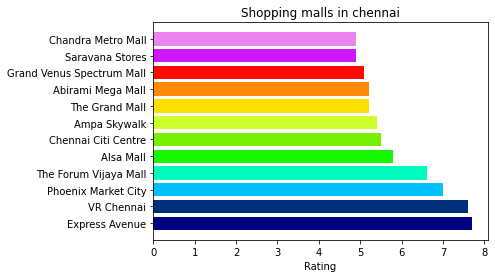

In [78]:
#Create a simple bar chart
colours = plt.get_cmap('gist_ncar')(
        np.linspace(0, .9, dfRated.shape[0]))

plt.barh(dfRated['Mall Name'], dfRated['Rating'],color = colours, label = 'Rating')
plt.xlabel('Rating')
plt.title('Shopping malls in chennai')
plt.show()


We will keep this dataset aside to use it in our final filtering

## Find a best location to open a new shopping mall

##### Criterian to fix the location:

Success of a shopping mall highly depends on the customer traffic. Lets look for a suitable place 
1. Based on the population distribution:
        Locations with high population are better places to get more customers
2. Based on popular and large localities:
       Localities having big residential properties, large IT parks, prominent companies attracts affulent customers



### Chennai population data
Latest census data is available for the year 2011.Ward wise population for Chennai is obtained from District Census Hand Book (DCHB) from census website of India  -https://censusindia.gov.in/2011census/dchb/DCHB_A/33/3302_PART_A_DCHB_CHENNAI.pdf

Challenge here was, during 2011 Chennai city had 155 wards soon afterwards it was extended to have 200 wards. Population data for the newly included wards were collected from DCHB of Kancheepuram.
https://censusindia.gov.in/2011census/dchb/3303_PART_B_DCHB_KANCHEEPURAM.pdf


Population data along with ward numbers are extracted to 'Chennai_wardwise_population_2011.csv'.


In [17]:
#Read the file to a pandas dataframe
dfPop = pd.read_csv('Chennai_wardwise_population_2011.csv')
#pd.set_option('display.max_rows',10)
dfPop

Ward No  Population
0          1       76760
1          2       66897
2          3       52995
3          4       15186
4          5       45204
..       ...         ...
195      196       21158
196      197        8958
197      198       35602
198      199        5037
199      200       29759

[200 rows x 2 columns]

#### Get geographical geometry from geoJson file 

Choropleth map will be a good choice to visualize the population distribution. To plot choropleth we need to get shape/geojson file for Chennai.

Thanks to https://github.com/mickeykedia/India-Maps for the the geojson, shape and allied files for Chennai city!

To read the geojson file geoPandas library is used.

In [18]:
#gpd - geopandas library
dfChepop = gpd.read_file('Chennai.geojson')
dfChepop.dropna(subset = ['WARD_NO'],inplace = True)
dfChepop['WARD_NO'] = dfChepop['WARD_NO'].astype(int)
dfChepop.sort_values('WARD_NO')

ZONE_NO  WARD_NO       ZONE_NAME               WARD_NAME  \
22        I        1   THIRUVOTTIYUR  Sathyavani muthu nagar   
23        I        2   THIRUVOTTIYUR             Kathivakkam   
24        I        3   THIRUVOTTIYUR    Annai Sivagami nagar   
25        I        4   THIRUVOTTIYUR                Ernavoor   
27        I        5   THIRUVOTTIYUR             Wimco nagar   
..      ...      ...             ...                     ...   
137      XV      196  SOZHINGANALLUR             Injambakkam   
138      XV      197  SOZHINGANALLUR              Karapakkam   
139      XV      198  SOZHINGANALLUR         Sozhianganallur   
140      XV      199  SOZHINGANALLUR                 Uthandi   
10       XV      200  SOZHINGANALLUR             Semmanchery   

                                              geometry  
22   POLYGON ((80.32680 13.21799, 80.32477 13.21806...  
23   POLYGON ((80.32273 13.20465, 80.32170 13.20495...  
24   POLYGON ((80.31870 13.18875, 80.31347 13.18989...  
25   POLYGON ((80.30908 13.18703, 80.30380 13.17564...  
27   POLYGON ((80.31270 13.16736, 80.30832 13.16822...  
..                                                 ...  
137  POLYGON ((80.25456 12.90422, 80.25357 12.90456...  
138  POLYGON ((80.24259 12.90757, 80.24062 12.90793...  
139  POLYGON ((80.25142 12.87904, 80.24542 12.88027...  
140  POLYGON ((80.23601 12.85899, 80.23488 12.86191...  
10   POLYGON ((80.24049 12.87426, 80.24064 12.87256...  

[200 rows x 5 columns]

We could see few ward names are missing. This is because there are various localities included in the ward and there is no common name. In such cas let us set zone name as ward name.

In [19]:
#For empty ward names assign the zone names
#rowind = dfChepop['WARD_NAME'].isnull()
rowind = dfChepop['WARD_NAME'] == ''
dfChepop.loc[rowind, 'WARD_NAME'] = dfChepop.loc[rowind, 'ZONE_NAME']
rowind = dfChepop['WARD_NAME'].isnull()
dfChepop.loc[rowind, 'WARD_NAME'] = dfChepop.loc[rowind, 'ZONE_NAME']

In [20]:
#lets check the result
dfChepop[dfChepop['WARD_NAME'] == ''].count()
#dfChepop[dfChepop['WARD_NAME'].isnull()].count()

ZONE_NO      0
WARD_NO      0
ZONE_NAME    0
WARD_NAME    0
geometry     0
dtype: int64

We can see that the boundry lines are available ward wise. Let us plot it.

### Visualize Chennai population density distribution using chloropleth map

Merge population dataframe and geo data frame

In [21]:
dfMerged = dfChepop.merge( dfPop, how='left', left_on = 'WARD_NO', right_on = 'Ward No')
dfMerged.sort_values('WARD_NO')

ZONE_NO  WARD_NO       ZONE_NAME               WARD_NAME  \
21        I        1   THIRUVOTTIYUR  Sathyavani muthu nagar   
22        I        2   THIRUVOTTIYUR             Kathivakkam   
23        I        3   THIRUVOTTIYUR    Annai Sivagami nagar   
24        I        4   THIRUVOTTIYUR                Ernavoor   
26        I        5   THIRUVOTTIYUR             Wimco nagar   
..      ...      ...             ...                     ...   
136      XV      196  SOZHINGANALLUR             Injambakkam   
137      XV      197  SOZHINGANALLUR              Karapakkam   
138      XV      198  SOZHINGANALLUR         Sozhianganallur   
139      XV      199  SOZHINGANALLUR                 Uthandi   
10       XV      200  SOZHINGANALLUR             Semmanchery   

                                              geometry  Ward No  Population  
21   POLYGON ((80.32680 13.21799, 80.32477 13.21806...        1       76760  
22   POLYGON ((80.32273 13.20465, 80.32170 13.20495...        2       66897  
23   POLYGON ((80.31870 13.18875, 80.31347 13.18989...        3       52995  
24   POLYGON ((80.30908 13.18703, 80.30380 13.17564...        4       15186  
26   POLYGON ((80.31270 13.16736, 80.30832 13.16822...        5       45204  
..                                                 ...      ...         ...  
136  POLYGON ((80.25456 12.90422, 80.25357 12.90456...      196       21158  
137  POLYGON ((80.24259 12.90757, 80.24062 12.90793...      197        8958  
138  POLYGON ((80.25142 12.87904, 80.24542 12.88027...      198       35602  
139  POLYGON ((80.23601 12.85899, 80.23488 12.86191...      199        5037  
10   POLYGON ((80.24049 12.87426, 80.24064 12.87256...      200       29759  

[200 rows x 7 columns]

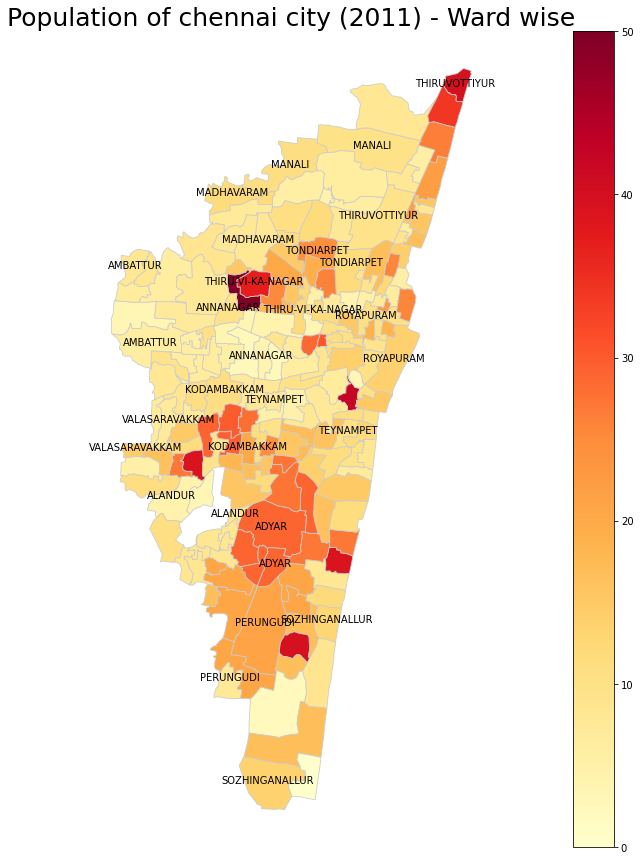

In [22]:
# set the value column that will be visualised
variable = 'Population'
# set the range for the choropleth values
vmin, vmax = 0, 50
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 15))
# remove the axis
ax.axis('off')
# add a title
ax.set_title('Population of chennai city (2011) - Ward wise', fontdict={'fontsize': '25', 'fontweight' : '3'})
# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
fig.colorbar(sm)
# create map
dfMerged.plot(column=variable, cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8')

# Add Labels
dfMerged['coords'] = dfMerged['geometry'].apply(lambda x: x.representative_point().coords[:])
dfMerged['coords'] = [coords[0] for coords in dfMerged['coords']]
temp = ''
for idx, row in dfMerged.iterrows():
    if not (temp == row['ZONE_NAME']):
        plt.annotate(s=row['ZONE_NAME'], xy=row['coords'],horizontalalignment='center')
        temp = row['ZONE_NAME']

#Save the map for reporting        
fig.savefig('Chennai population distribution ward wise.png', dpi=300)


In [23]:
dfMerged[dfMerged['WARD_NAME'].isnull()].count()
#dfMerged[dfMerged['WARD_NAME'] == ''].count()

ZONE_NO       0
WARD_NO       0
ZONE_NAME     0
WARD_NAME     0
geometry      0
Ward No       0
Population    0
coords        0
dtype: int64

Lets create a folium map to visualize the population

In [24]:
mapfinal = folium.Map(location=[chelat, chelng], zoom_start=11)

folium.Choropleth(
    geo_data = dfMerged,
    data = dfMerged,
    columns = ['WARD_NO','Population'],
    key_on = 'feature.properties.WARD_NO',
    fill_color = 'YlOrRd', 
    fill_opacity = 0.7, 
    line_opacity = 0.2,
    legend_name = 'Chennai Population(2011) - Ward wise'
).add_to(mapfinal)

Add tool tip to the map

In [25]:
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
shl = folium.features.GeoJson(
    dfMerged,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['WARD_NO','WARD_NAME', 'Population'],
        aliases=['Ward No: ','Ward Name: ', 'Population: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
mapfinal.add_child(shl)
mapfinal.keep_in_front(shl)
folium.LayerControl().add_to(mapfinal)
mapfinal

In [26]:
rainbow = ['Orange', 'Blue', 'Red']

# add markers to the map
for lat, lng, name,rating,cluster in zip(dfBase['Latitude'], dfBase['Longitude'], dfBase['Mall Name'], dfBase['Rating'], dfBase['Group']):
    label = folium.Popup(str(name) + '  Rating: ' + str(rating) + '  Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(mapfinal)
       

In [27]:
#Add Legend
from folium.plugins import FloatImage
image_file = 'legend.PNG'

FloatImage(image_file, bottom=20, left=70).add_to(mapfinal)
mapfinal

### Lets have a look at the popular and dense localities in Chennai where the potential customers for shopping mall is high


Employees of MNCs and IT firms are identified as high spending populations in the city. There are quite a number of IT parks in the city that hosts these companies. Big residential properties such as multi storied apartments and villas are developing centering these IT Parks. We can comfortably conclued that these localities will be a promising sites to start a new retail business such as  ashopping mall.
Information about the locations of IT parks in Chennai and area in lakh sqft are collected from wikipedia website, cleaned up and assembled in the file 'Chennai_Hots.csv'

In [28]:
#Read the file to a dataframe
dfhots = pd.read_csv('Chennai_Hots.csv',encoding='latin1')
dfhots

Locality   Area                  Address
0                      DLF -IT park   70.00       Manapakkam,Chennai
1            Shriram The Gateway SEZ  50.00    Perungalathur,Chennai
2                          ESTRA SEZ  45.00  Ayyapanthangal, Chennai
3         Embassy Splendid Tech Zone  40.00      Pallavaram, Chennai
4   ETL Infrastructure - Chennai One  37.80             Thoraipakkam
..                               ...    ...                      ...
84              Bhanumathi & others    0.93        Perungudi,Chennai
85                  Quanta Engineers   0.89        Teynampet,Chennai
86     Ramaniyam - Baid Hi-Tech Park   0.80     Tiruvanmiyur,Chennai
87               Ramaniyam - Bristol   0.80                   Guindy
88                   Aravind IT park   0.50               karapakkam

[89 rows x 3 columns]

Get geocoordinates for the locations in the dataframe using Nominatim


In [29]:
#Get ward number,latitude and Longitude 
lstLat = []
lstLng = []
lstward = []
#geolocator = Nominatim(user_agent = "plea")
for add in dfhots['Address']:
    location = geolocator.geocode(add)
    tmp = location.address
    #Extract ward number from address
    try:
        pos = re.search('Ward',tmp).span()[1] + 1
        lstward.append(tmp[pos:pos+3].strip(','))
    except:
        lstward.append('')
    #Get latitude and longitude
    try:
        lstLat.append(location.latitude)
        lstLng.append(location.longitude)
    except:
        print(add)

In [30]:
#Add the list to the datafrme
dfhots['Latitude'] = lstLat
dfhots['Longitude'] = lstLng
dfhots['Ward_no'] = lstward

dfhots.head(5)

Locality  Area                  Address   Latitude  \
0                     DLF -IT park   70.0       Manapakkam,Chennai  13.014753   
1           Shriram The Gateway SEZ  50.0    Perungalathur,Chennai  12.927605   
2                         ESTRA SEZ  45.0  Ayyapanthangal, Chennai  13.037793   
3        Embassy Splendid Tech Zone  40.0      Pallavaram, Chennai  12.993374   
4  ETL Infrastructure - Chennai One  37.8             Thoraipakkam  12.930069   

   Longitude Ward_no  
0  80.174493     157  
1  80.099965          
2  80.134942     150  
3  80.172587          
4  80.230022     195

### Add popular localities to the final map

In [31]:

# add Localities marker to the final map
for lat, lng, name,area in zip(dfhots['Latitude'], dfhots['Longitude'], dfhots['Locality'], dfhots['Area']):
    label = folium.Popup(str(name) + '  Area: ' + str(area) + '  Lakh Sqft', parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='Green',
        fill=True,
        fill_color='Green',
        fill_opacity=0.2).add_to(mapfinal)
  
mapfinal.save('Finalmap.html')
mapfinal


Everything looks good so far. Its time now to extract the result.

### Filter out the results

##### First let us list out top 10 densely populated areas in the city.

In [32]:
dfToppop = dfMerged.sort_values('Population', ascending=False).head(10).reset_index()
dfToppop[['WARD_NO', 'WARD_NAME']]

WARD_NO               WARD_NAME
0       65       THIRU-VI-KA-NAGAR
1       63    Komaleeswaran pettai
2        1  Sathyavani muthu nagar
3      194    Okkiyam thuraipakkam
4      182                   ADYAR
5      155               Ramapuram
6       64                Kolathur
7        2             Kathivakkam
8       75       THIRU-VI-KA-NAGAR
9      129              Saligramam

#### List out localities with maximum number of hot spots

In order to list the localities based on ward number we may have to clean the dataset a bit


##### List out the ward numbers that have maximum hot spots

In [33]:
#Groupby ward number
dfhotwards = dfhots.groupby('Ward_no').count().sort_values('Locality',ascending = False).head(10)
dfhotwards = dfhotwards.iloc[1:]


##### Lets see if there are wards that are both densely populated as well as hot spot

In [34]:
print(dfhotwards.index.values)
print(dfToppop['WARD_NO'])

['197' '180' '195' '184' '86' '170' '81' '185' '174']
0     65
1     63
2      1
3    194
4    182
5    155
6     64
7      2
8     75
9    129
Name: WARD_NO, dtype: int32


From the results it is clear that there are **no** matching ward numbers in both the categories. Important reason for this mismatch is the census data is nearly 10 years old. After the census, Chennai is converted to Greater Chennai enclosing 200 wards. The city has grown manyfold since then. Spending population started growing in south Chennai. Also many of these population are floating population having their native somewhere else. So they may not get reflected in the city population census.

For now, **since the census data available currently is too old we will not consider population as a major deciding factor** to solve our problem. However it is to be noted that when accurate census data is available, it will act as a major deciding factor to solve our problem.

### Fix promising localities based on spending population

Visualize Wards vs Number of hot localities

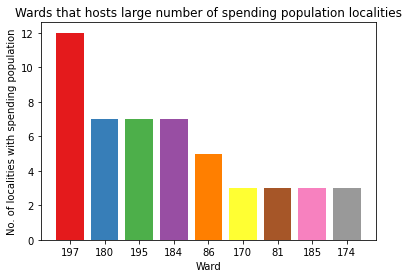

In [35]:
#Create a simple bar chart
colours = plt.get_cmap('Set1')(
        np.linspace(0, .9, dfhotwards.shape[0]))

plt.bar(dfhotwards.index, dfhotwards['Locality'],color = colours)
plt.xlabel('Ward')
plt.ylabel('No. of localities with spending population')
plt.title('Wards that hosts large number of spending population localities')
plt.show()

### Let us see if there are places that has spending population with no malls within 5 km distance

Get the distance between each spending location with every mall. List out the localities that have **no malls within 5 kms**.

In [36]:
dfNew = pd.DataFrame(columns = ['Locality', 'Latitude', 'Longitude','Malls within 5 km'])
for lat,lng,loc in zip(dfhots['Latitude'], dfhots['Longitude'], dfhots['Locality']):
    cnt = 0
    for latm,lngm in zip(dfBase['Latitude'], dfBase['Longitude']):
        distance = geodesic((lat,lng),(latm,lngm)).km
        if distance < 5 :
            cnt = cnt +1
    
    dfNew.loc[len(dfNew.index)] = [loc,lat,lng,cnt]

In [37]:
print('Hot spots that has no malls within 5 kms: ')
print(dfNew[dfNew['Malls within 5 km'] == 0].reset_index(drop = True))


Hot spots that has no malls within 5 kms: 
                    Locality   Latitude  Longitude Malls within 5 km
0    Shriram The Gateway SEZ  12.927605  80.099965                 0
1              SRM Tech Park  12.820757  80.036874                 0
2       Ambattur Clothing Co  13.119375  80.150765                 0
3           Tidel Park Avadi  13.124234  80.052364                 0
4                        NaN  46.314475  11.048029                 0
5                       TNPL  13.119375  80.150765                 0
6  Alliance Orchid Tech Park  13.119375  80.150765                 0
7           Arun Fabricators  12.939937  79.989277                 0
8    Krishnan Sivagami Trust  12.786249  80.221994                 0


In [38]:
#Avg number of malls within 5 kms
avg = dfNew['Malls within 5 km'].mean()
avg

4.719101123595506

Visualize them using folium map

In [39]:
mymap2 = folium.Map(location=[chelat, chelng], zoom_start=12)

# Add new clusters
for lat, lng, name in zip(dfhots['Latitude'], dfhots['Longitude'], dfhots['Locality']):
    label = folium.Popup(str(name), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='red',
        fill=False
        ).add_to(mymap2)

    
for lat,lng,name in zip(dfNew['Latitude'], dfNew['Longitude'], dfNew['Locality']):
    folium.Marker([lat, lng],icon=folium.Icon(color='purple'),
        popup='Hot spot - ' + str(name)).add_to(mymap2)
mymap2

#### Not have enough spending population. We cannot recommend these areas

From the above map, it is clear that all listed locations lies **outside city** limit. Also there are no prominent spending population around these locations. So we cannot recommend these locations as best places to start a new mall. 

On average there are **5 malls exists within 5 km radius of each hotspot**.Since all the hot areas in the city already hosts atleast one mall within 5 km radius we will now carefully look for a better spot.

We will cluster the spending population locations and filter the spots based on its density and availability of malls nearby. **For the first level filtering we will use all malls. For final filtering we will consider only high and medium rated mall density.**

#### Cluster spending population

We will now filter areas that have dense spending population.

Let us group the spending population into five based on location.

In [40]:
dfhots.dropna(subset = ['Locality'],inplace = True)
#dfhots.drop('Group',axis = 1, inplace = True)
n = 5
dfClusterh = pd.DataFrame(dfhots[['Latitude', 'Longitude']])
kmeansh = KMeans(n_clusters = n, random_state = 2).fit(dfClusterh)
dfhots.insert(3,'Group',kmeansh.labels_)
dfhots

Locality   Area                  Address  Group  \
0                      DLF -IT park   70.00       Manapakkam,Chennai      0   
1            Shriram The Gateway SEZ  50.00    Perungalathur,Chennai      3   
2                          ESTRA SEZ  45.00  Ayyapanthangal, Chennai      1   
3         Embassy Splendid Tech Zone  40.00      Pallavaram, Chennai      0   
4   ETL Infrastructure - Chennai One  37.80             Thoraipakkam      2   
..                               ...    ...                      ...    ...   
84              Bhanumathi & others    0.93        Perungudi,Chennai      0   
85                  Quanta Engineers   0.89        Teynampet,Chennai      0   
86     Ramaniyam - Baid Hi-Tech Park   0.80     Tiruvanmiyur,Chennai      0   
87               Ramaniyam - Bristol   0.80                   Guindy      0   
88                   Aravind IT park   0.50               karapakkam      2   

     Latitude  Longitude Ward_no  
0   13.014753  80.174493     157  
1   12.927605  80.099965          
2   13.037793  80.134942     150  
3   12.993374  80.172587          
4   12.930069  80.230022     195  
..        ...        ...     ...  
84  12.971024  80.241805     184  
85  13.044324  80.249846     118  
86  12.988982  80.251587     180  
87  13.008710  80.220365     174  
88  12.911707  80.227720     197  

[88 rows x 7 columns]

In [77]:
#Visualize the clusters along with the malls
mymap = folium.Map(location=[chelat, chelng], zoom_start=11)
rainbow = ['Green', 'Purple','Black','darkred','darkblue']

# Add spending population clusters
for lat, lng, name,cluster in zip(dfhots['Latitude'], dfhots['Longitude'], dfhots['Locality'], dfhots['Group']):
    label = folium.Popup(str(name) + '  Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=False,
        fill_opacity=0.7).add_to(mymap)

# Add existing malls. We will consider all malls for first level filtering
for lat, lng, name in zip(dfBase['Latitude'], dfBase['Longitude'], dfBase['Mall Name']):
    label = folium.Popup(str(name) , parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Red',
        fill=True,
        fill_color='Red',
        fill_opacity=0.7).add_to(mymap)
mymap

### Filter localities
From the map above, we derive the following insights:


###### We can "exclude" the following localities from our 'target'  for the following reasons:
1. North part of Chennai:  It is primarily an industrial area. Does not have spending population. (includes tiruvotriyur, washermanpet, VOC nagar etc)
2. Central part of Chennai: QUite large number of malls already exists in this part of chennai (around Thousands lights, Royapettah, Teynampet, West Mambalam)
3. West chennai: Few malls exists already in this part. Does not seems to have large number of spending population as there are only few big commercial sites and IT parks
4. South most Chennai: (Navalur, Siruseri etc.,) Hosts three malls already. Although these are not high rated malls, we cannot recommend this location since there is no enough spending population around

##### Following areas can can be considered  as promising localities

South East part of Chennai(Cluster 0) : Areas such as MRC Nagar, Raja Annamalaipuram, Kotturpuram, Adyar, Besant Nagarand Thiruvanmiyur proves to be promising localities for opening a new mall as these are considered posh areas with large number of spending residents. It also encloses large number of big commercial firms. Areas on OMR like Kottivakkam, Palavakkam, Kandhanchavadi, Thuraippakkam and Sholinganallur also proves to be promising localities as these encloses the fast growing IT parks with large number of spending residents around. Important point to be noted here is there are no big prominent malls exists in these localities.

Let us dig further to see if we can precisely name few localities.

For further analysis, **we will consider only high and medium rated malls so that we can predict the competition level**.

At this point, we will select **cluster 0 and 2 as our targets** as there is only one mall exists there with bunch of spending localities.

We will focus further on cluster 0. Extract only this cluster to a dataframe. Apply KMeans clustering again to further get closer to our target.

In [57]:
#Extract only cluster 0 to a dataframe
dfspots  =pd.DataFrame(dfhots[dfhots['Group'] == 0])

In [58]:
# Cluster the dataset further into five groups
dfspots.drop('Group',axis = 1, inplace = True)
n = 5
dfclus = pd.DataFrame(dfspots[['Latitude', 'Longitude']])
kms = KMeans(n_clusters = n, random_state = 3).fit(dfclus)
dfspots.insert(3,'Group',kms.labels_)

In [65]:
#Visualize the clusters
mymap1 = folium.Map(location=[chelat, chelng], zoom_start=12)

rainbow = ['Green', 'Yellow','blue','purple','black']

# Add new clusters
for lat, lng, name,cluster in zip(dfspots['Latitude'], dfspots['Longitude'], dfspots['Locality'], dfspots['Group']):
    label = folium.Popup(str(name) + '  Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=False
        ).add_to(mymap1)
    
# Add high and medium rated malls
for lat, lng, name in zip(dfRated['Latitude'], dfRated['Longitude'], dfRated['Mall Name']):
    label = folium.Popup(str(name) , parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='lightred',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(mymap1)

mymap1

##### Insights from above plot

1. **Cluster 4** has bunch of spending localities with **no existing malls**. We will consider this as one of our target.
2. **Cluster 2** also is promising locality with no malls on eastern side of the city.
3. Cluster 1 and cluster 3 combined can also be considered as target.

###### Our final findings can be summarized as :

1. Center of 'cluster 4'

2. Eastern side of 'cluster 2'. Exclude localities in western side as there are few malls exists there already.

3. Locality that exists 'between' the above two clusters.

4. Center of Cluster 1 and Cluster 3 combined

5. Cluster 2 of previous clustering using dfhots.
 

In [73]:
# Calculate the mean of latitude and longitude to find center of a cluster
# Create a dataframe to store the results

dfResult  = pd.DataFrame(columns = ['Latitude', 'Longitude'])
######## 1.  Center of 'cluster 4'  ############
df4  = pd.DataFrame(dfspots[dfspots['Group'] == 4])
mlat4 = df4['Latitude'].mean()
mlng4 = df4['Longitude'].mean()
dfResult.loc[len(dfResult)] = [mlat4,mlng4]

##########  2. Eastern side of 'cluster 2'  ##############
df2  = pd.DataFrame(dfspots[dfspots['Group'] == 2])
#Exclude the outlier on west
df2 = df2[df2['Address'] != 'Mahindra city,Chennai']
mlat2 = df2['Latitude'].mean()
mlng2 = df2['Longitude'].mean()
dfResult.loc[len(dfResult)] = [mlat2,mlng2]

#############  3. Locality that exists 'between' the above two clusters. ############
mlatc = (mlat2+mlat4)/2
mlngc = (mlng2+mlng4)/2
dfResult.loc[len(dfResult)] = [mlatc,mlngc]

############  4. Center of Cluster 1 and Cluster 3 combined  #################
df13  = pd.DataFrame(dfspots[(dfspots['Group'] == 1)| (dfspots['Group'] == 3)])
dfResult.loc[len(dfResult)] = [df13['Latitude'].mean(), df13['Longitude'].mean()]

#############  5. Cluster 2 of previous clustering using dfhots. ############
dfsouth  = pd.DataFrame(dfhots[dfhots['Group'] == 2])

for lat, lng, name,cluster in zip(dfsouth['Latitude'], dfsouth['Longitude'], dfsouth['Locality'], dfsouth['Group']):
    label = folium.Popup(str(name) + '  Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='Orange',
        fill=False
        ).add_to(mymap1)

dfResult.loc[len(dfResult)] = [dfsouth['Latitude'].mean(), dfsouth['Longitude'].mean()]
  


### Display the Results

Display the address of the promising localities

In [74]:
#Get the landmarks for the malls using nominatim
lstadd=[]
lstpc = []

for lat,lng in zip(dfResult['Latitude'], dfResult['Longitude']):
    address = geolocator.reverse((lat,lng)).address
    tmp = address.split(',')
    lstpc.append(tmp[-2])
    lstadd.append(','.join(tmp[0:4]))
dfResult['Address'] = lstadd
dfResult['Postalcode'] = lstpc


 ##### As a final step let us check if there are malls within 3 km radius
 
 Use geodesic of geopy library to find distance between two geo coordinates

In [81]:
lstcnt=[]
for lat,lng in zip(dfResult['Latitude'], dfResult['Longitude']):
    cnt = 0
    for latm,lngm in zip(dfRated['Latitude'], dfRated['Longitude']):
        distance = geodesic((lat,lng),(latm,lngm)).km
        if distance < 3 :
            cnt = cnt +1
    lstcnt.append(cnt)
       
dfResult['High rated malls within 3 km'] = lstcnt 
dfResult = dfResult.sort_values(['High rated malls within 3 km']).reset_index(drop = True)
dfResult

Latitude  Longitude  \
0  12.912769  80.228272   
1  13.000513  80.256191   
2  12.975507  80.245895   
3  13.025520  80.266486   
4  13.008968  80.200370   

                                                                      Address  \
0  Prestige Cyber Towers, Rajiv Gandhi Salai, Navalur, Zone 15 Sholinganallur   
1     Vasantha Bhavan, Dr Muthulakshmi Salai, Bakthavatchalam Nagar, Ward 175   
2         Nehru Nagar Industrial Estate, Ward 183, Zone 14 Perungudi, Chennai   
3                              Mandaveli, Ward 126, Zone 9 Teynampet, Chennai   
4               M Auto, Paul Wells Road, St. Thomas Mount Cantonment, Alandur   

  Postalcode  High rated malls within 3 km  
0     603103                             0  
1     600020                             0  
2     600041                             1  
3     600028                             1  
4     600016                             1

### Visualize the results

In [69]:

for lat,lng,add,pc in zip(dfResult['Latitude'], dfResult['Longitude'], dfResult['Address'], dfResult['Postalcode']):
    folium.Marker([lat, lng],icon=folium.Icon(color='green'),
        popup='Proposed spot - ' + str(add) + '- ' +  str(pc)).add_to(mymap1)
mymap1

##### Plot them to get clear result

## Conclusion:

I tried to fix optimal locations based on population density and spending population density. Since we do not have latest census data for Chennai, it did not give good picture to use in our current analysis.Locations are filtered out considering spending population locations. On the average we could see there is atleast one mall exist within 3 km radius of dense hot localities.  Based on my reserch, **south and south east part of Chennai** are found to be best areas to open a new mall since it hosts dense spending population and no/only few high and medium rated malls existing within 3 km radius. This includes **Mandaveli, Adyar, Besant Nagar, Thiruvanmiyur,Taramani and Karapakkam**.
This can be further narrowed down to the following spots.

In [79]:
pd.set_option('display.max_colwidth', None)
dfResult

Latitude  Longitude  \
0  13.000513  80.256191   
1  12.912769  80.228272   
2  13.025520  80.266486   
3  12.975507  80.245895   
4  13.008968  80.200370   

                                                                      Address  \
0     Vasantha Bhavan, Dr Muthulakshmi Salai, Bakthavatchalam Nagar, Ward 175   
1  Prestige Cyber Towers, Rajiv Gandhi Salai, Navalur, Zone 15 Sholinganallur   
2                              Mandaveli, Ward 126, Zone 9 Teynampet, Chennai   
3         Nehru Nagar Industrial Estate, Ward 183, Zone 14 Perungudi, Chennai   
4               M Auto, Paul Wells Road, St. Thomas Mount Cantonment, Alandur   

  Postalcode  High rated malls within 3 km  
0     600020                             0  
1     603103                             0  
2     600028                             1  
3     600041                             1  
4     600016                             1

### Future Direction:

‘Rating’ of the malls could be a valuable feature to get precise competition level .Foursquare did not provide ratings for all malls. Most of the malls has no reviews or ratings. Since this project demands the usage of Foursquare API, I did not use other APIs such as Google places. Google places gives more precise data as far as Indian neighbourhoods are considered. This project can be further fine-tuned by using accurate ratings of existing malls. 
Population density can also be a good deciding factor once latest census data is available. 
So this project can further be fine-tuned taking into account the couple of fore said features to achieve better results. 
	
   Apart from shopping malls, this project can also be used to fix localities for other retail businesses such as a restaurant or an electronic shop by using the respective data.

### References:
1.	Foursquare API documentation
2.	Geopy Documentation
3.	District Census Handbook – Chennai
4.	District Census Handbook – Kancheepuram
5.	Chennai’s IT parks – Wikipedia


Thank you!
